## Analytics on S3 data (Parquet)

In [1]:
import boto3
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os
from pyspark.sql import SparkSession

# read config file
config = configparser.ConfigParser()
config.read("dl.cfg")

['dl.cfg']

#### Define variables

In [2]:
# data
output_data = config.get("S3", "output_data")

# config
AWS_KEY = config.get("default", "aws_access_key_id")
AWS_SECRET = config.get("default", "aws_secret_access_key")
REGION = config.get("S3", "region")

#### Launch Spark session

In [3]:
spark = SparkSession \
    .builder \
    .appName("sparkify-etl") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.0") \
    .config("spark.hadoop.fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.access.key", AWS_KEY) \
    .config("spark.hadoop.fs.s3a.secret.key", AWS_SECRET) \
    .getOrCreate()

"""
notes:
s3a client interaction with buckets - hadoop property - fs.s3a.access.key & fs.s3a.secret.key
https://hadoop.apache.org/docs/r3.2.0/hadoop-aws/tools/hadoop-aws/index.html
"""

'\nnotes:\ns3a client interaction with buckets - hadoop property - fs.s3a.access.key & fs.s3a.secret.key\nhttps://hadoop.apache.org/docs/r3.2.0/hadoop-aws/tools/hadoop-aws/index.html\n'

#### List S3 buckets (output storage location) in AWS

In [4]:
s3 = boto3.client("s3",
                  region_name=REGION,
                  aws_access_key_id=AWS_KEY,
                  aws_secret_access_key=AWS_SECRET
                  )
response = s3.list_buckets()
bucket_list = [bucket["Name"] for bucket in response["Buckets"]]
print("buckets:", bucket_list)

buckets: ['abreufreire-output', 'abreufreire-script']


#### Read data from S3 bucket (Parquet format)

In [6]:
songplays_df = spark.read.parquet(os.path.join(output_data, "songplays/year=*/month=*/*.parquet"))

In [7]:
artists_df = spark.read.parquet(os.path.join(output_data, "artists/*.parquet"))

In [8]:
songs_df = spark.read.parquet(os.path.join(output_data, "songs/year=*/artist_id=*/*.parquet"))

In [9]:
time_df = spark.read.parquet(os.path.join(output_data, "time/year=*/month=*/*.parquet"))

In [10]:
users_df = spark.read.parquet(os.path.join(output_data, "users/*.parquet"))

#### Plot data size

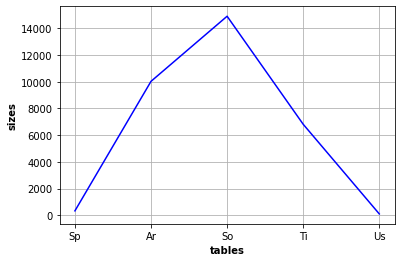

In [16]:
dataframes = [songplays_df, artists_df, songs_df, time_df, users_df]
rows = []
for i, df in enumerate(dataframes):
    size = df.count()
    rows.append(size)

# tables: songplays (Sp), artists (Ar), songs (So), time (Ti), users (Us)
tables = ["Sp", "Ar", "So", "Ti", "Us"]

# plt.tight_layout()
plt.xlabel("tables", weight='bold')
plt.ylabel("size", weight='bold')
plt.plot(tables, rows, color='blue')
plt.grid()
plt.show()

#### Views from dataframes

In [12]:
songplays_df.createOrReplaceTempView("songplays")
artists_df.createOrReplaceTempView("artists")
songs_df.createOrReplaceTempView("songs")
time_df.createOrReplaceTempView("time")
users_df.createOrReplaceTempView("users")

#### Activity (songs listened) by week day:

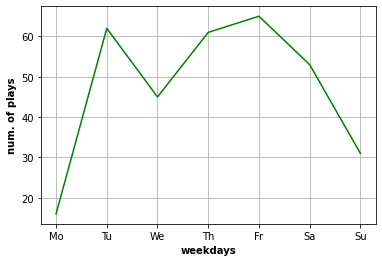

In [15]:
n_plays_by_day_df = spark.sql("""SELECT COUNT (*) AS n_plays FROM songplays AS sp \
    JOIN time ON sp.start_time = time.start_time \
    GROUP BY time.weekday
    ORDER BY time.weekday;""")

n_plays_by_day_list = n_plays_by_day_df.select("n_plays").rdd.flatMap(lambda x: x).collect()

weekdays = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]

# plt.tight_layout()
plt.xlabel("weekdays", weight='bold')
plt.ylabel("num. of plays", weight='bold')
plt.plot(weekdays, n_plays_by_day_list, color='green')
plt.grid()
plt.show()